In [338]:
%pylab inline 
import numpy as np
from matplotlib import pylab
np.set_printoptions(precision=3, suppress=1, linewidth=100)

Populating the interactive namespace from numpy and matplotlib


In [339]:
import bnpy

In [340]:
def minnonzero(Arr, thr=0.001):
    return Arr[Arr > thr].min()

In [341]:
import BarsK10V900
Data = BarsK10V900.get_data(nDocTotal=300, nWordsPerDoc=100)


In [342]:
LPkwargs = dict(
    nCoordAscentItersLP=50,
    convThrLP=0.001,
    restartLP=1,
    )

In [343]:
hmodel, Info = bnpy.run(Data, 'HDPTopicModel', 'Mult', 'moVB',
                        lam=0.1, alpha=0.5, gamma=10, 
                        nLap=10, nBatch=2, printEvery=25,
                        initname='truelabelsandjunk',
                        initKextra=1,
                       **LPkwargs)

{'initMinWordsPerDoc': 100, 'K': 6, 'initBlockLen': 20, 'initMinDocPerWord': 10, 'initarg': 0.0, 'taskid': 1, 'initLapFrac': -1.0, 'initDim': 1000, 'initLP': 'none'} <<<
[ 2332.823  2322.655  1853.305  2347.941  2466.96   2732.796  3096.074  2267.893  2346.962  2247.891
  1217.7  ]
Toy Bars Data with 10 true topics. Each doc uses 1-3 bars.
Entire Dataset Summary:
  total size: 300 units
  batch size: 150 units
  num. batches: 2
Data for Initialization:
  size: 300 units (documents)
  vocab size: 900
  min    5%   50%   95%   max 
   73    77    84    92    99  nUniqueTokensPerDoc
  100   100   100   100   100  nTotalTokensPerDoc
Hist of word_count across tokens 
      1      2      3    <10   <100  >=100
   0.84   0.14   0.02     61      0      0
Hist of unique docs per word type
     <1    <10   <100  >=100
      0      0   >.99      0
Allocation Model:  HDP model with K=11 active comps. gamma=10.00. alpha=0.50
Obs. Data  Model:  Multinomial over finite vocabulary.
Obs. Data  Prior:  

In [344]:
LP = hmodel.calc_local_params(Data, **LPkwargs)
SS = hmodel.get_global_suff_stats(Data, LP, doPrecompEntropy=1)

In [351]:
print LP['resp'].sum()
print SS.getCountVec()

25233.0
[ 2962.485  2823.985  2344.814  2871.783  3068.252  3483.252  3896.152  2889.778  2917.103  2727.897
    14.499]


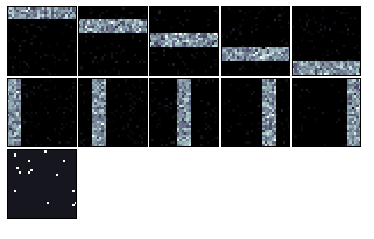

In [352]:
bnpy.viz.PlotComps.plotCompsFromHModel(hmodel)

In [353]:
respS = LP['resp'].copy()

In [354]:
respS[respS < 0.001] = 1e-100

In [355]:
respS /= respS.sum(axis=1)[:,np.newaxis]

In [356]:
respS[respS > 1e-50].min()

0.001002416927054061

In [357]:
newLP = hmodel.allocModel.initLPFromResp(Data, dict(resp=respS))
newLP['E_log_soft_ev'] = LP['E_log_soft_ev']

In [360]:
newSS = hmodel.get_global_suff_stats(Data, newLP, doPrecompEntropy=1)
print newLP['resp'].sum()

25233.0


In [361]:
print SS.getELBOTerm('Hresp').sum()
print newSS.getELBOTerm('Hresp').sum()

2813.25520496
2808.33061831


In [362]:
print hmodel.calc_evidence(SS=SS)
print hmodel.calc_evidence(SS=newSS)

-6.14932268934
-6.15699505526


# Create "subdivision resp" matrix, reassigning all tokens in the junk topic.

In [109]:
trueResp = Data.TrueParams['resp'].copy()
trueResp[trueResp < 0.001] = 1e-100
trueResp /= trueResp.sum(axis=1)[:,np.newaxis]

In [110]:
mask = newLP['resp'][:, -1] > 0.0001

In [144]:
maskpropResp = np.zeros((mask.size, trueResp.shape[1]))
maskpropResp = trueResp[mask, :]
maskpropResp *= newLP['resp'][mask, -1][:,np.newaxis]
Knew = 10
Korig = 10

In [145]:
maskpropResp.sum(axis=1)

array([ 0.997,  0.895,  0.929,  0.937,  1.   ,  0.958,  0.965,  0.947,
        0.944,  1.   ,  0.932,  0.998,  0.001,  1.   ,  0.998,  0.998])

In [146]:
newLP['resp'][mask, -1]

array([ 0.997,  0.895,  0.929,  0.937,  1.   ,  0.958,  0.965,  0.947,
        0.944,  1.   ,  0.932,  0.998,  0.001,  1.   ,  0.998,  0.998])

In [147]:
maskpropResp

array([[ 0.843,  0.01 ,  0.121,  0.023,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.752,  0.009,  0.122,  0.012,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.692,  0.007,  0.227,  0.004,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.796,  0.015,  0.107,  0.019,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.772,  0.013,  0.191,  0.021,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.002],
       [ 0.017,  0.621,  0.298,  0.023,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.015,  0.59 ,  0.348,  0.012,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.024,  0.739,  0.175,  0.009,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.004,  0.882,  0.025,  0.033,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.004,  0.838,  0.125,  0.03 ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.002,  0.   ],
       [ 0.013,  0.002,  0.164

In [175]:
propResp = 1e-100 * np.ones((newLP['resp'].shape[0], newLP['resp'].shape[1] - 1 + Knew))

In [176]:
propResp[:, :10] = newLP['resp'][:, :10]

In [177]:
propResp[mask, 10:] = maskpropResp

In [178]:
propLP = hmodel.allocModel.initLPFromResp(Data, dict(resp=propResp))

In [179]:
propLP['resp'].sum(axis=1)

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [180]:
print propLP.keys()

['thetaRem', 'ElogPi', 'resp', 'digammaSumTheta', 'DocTopicCount', 'ElogPiRem', 'theta']


In [203]:
mPairIDs=[]
for k in xrange(10):
    mPairIDs.append((k, Korig+k))
print mPairIDs
propLP['resp'].shape
propLP.keys()

[(0, 10), (1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 16), (7, 17), (8, 18), (9, 19)]


['thetaRem',
 'ElogPi',
 'resp',
 'digammaSumTheta',
 'DocTopicCount',
 'ElogPiRem',
 'theta']

In [210]:
propSS = hmodel.get_global_suff_stats(Data, propLP)
propModel = hmodel.copy()
propModel.update_global_params(propSS)
propSS = propModel.get_global_suff_stats(Data, propLP, doPrecompEntropy=1, doPrecompMergeEntropy=1, mPairIDs=mPairIDs)

propModel.update_global_params(propSS)
propELBO = propModel.calc_evidence(SS=propSS)

In [211]:
propSS.getMergeTerm('Hresp')[0,10]

286.70952742478744

In [212]:
propSS.getELBOTerm('Hresp')

array([ 285.214,  270.269,  262.02 ,  246.465,  320.175,  292.845,
        289.422,  299.647,  276.865,  264.914,    1.496,    1.484,
          4.137,    1.643,    0.016,    0.   ,    0.   ,    0.   ,
          0.014,    0.077])

In [215]:
finalModel, finalSS, finalELBO, Info = bnpy.mergemove.MergeMove.run_many_merge_moves(propModel, propSS, propELBO, mPairIDs)

In [216]:
finalModel.calc_evidence(SS=finalSS)

-6.1491438248624188

In [218]:
hmodel.calc_evidence(SS=SS)

-6.1493226893367421

In [219]:
propModel.calc_evidence(SS=propSS)

-6.1722018524285041

In [224]:
del finalModel.allocModel.rho
del finalModel.allocModel.omega
finalModel.allocModel.update_global_params(finalSS)

In [225]:
finalModel.calc_evidence(SS=finalSS)

-6.1490645905937038

In [227]:
del finalModel.allocModel.rho
del finalModel.allocModel.omega
finalModel.allocModel.update_global_params(finalSS)
finalModel.calc_evidence(SS=finalSS)

-6.1490645905937038

In [228]:
del hmodel.allocModel.rho
hmodel.allocModel.update_global_params(SS)
print hmodel.calc_evidence(SS=SS)


-6.1492981155


# Alternative construction: using existing suff stats

In [363]:
np.flatnonzero(mask)

array([13561, 13562, 13563, 13564, 13565, 13566, 13567, 13568, 13569, 13570, 13633, 13634, 13637,
       13638, 13639, 13640])

In [364]:
LP['resp'][mask, :]

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.003,  0.   ,  0.   ,  0.   ,  0.   ,  0.997],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.105,  0.   ,  0.   ,  0.   ,  0.   ,  0.895],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.071,  0.   ,  0.   ,  0.   ,  0.   ,  0.929],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.063,  0.   ,  0.   ,  0.   ,  0.937],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.042,  0.   ,  0.   ,  0.   ,  0.   ,  0.958],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.035,  0.   ,  0.   ,  0.   ,  0.965],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.053,  0.   ,  0.   ,  0.   ,  0.   ,  0.947],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.056,  0.   ,  0.   ,  0.   ,  0.944],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  0.   ,  0.   

In [234]:
trueResp[mask, :]

array([[ 0.846,  0.01 ,  0.121,  0.023,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.84 ,  0.01 ,  0.136,  0.013,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.745,  0.007,  0.244,  0.004,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.85 ,  0.016,  0.114,  0.02 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.772,  0.013,  0.191,  0.021,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.002],
       [ 0.017,  0.648,  0.311,  0.024,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.015,  0.611,  0.36 ,  0.013,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.025,  0.781,  0.185,  0.009,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.004,  0.934,  0.027,  0.035,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.004,  0.838,  0.125,  0.03 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.002,  0.   ],
       [ 0.014,  0.002,  0.176,  0.808,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.009,  0.00

In [243]:
LP['DocTopicCount'][161, :]

array([  0.   ,   0.   ,  82.507,   0.   ,   0.   ,   1.62 ,   1.374,   0.   ,   0.   ,   0.   ,
        14.499])

In [244]:
propLP['DocTopicCount'][161, :10] + propLP['DocTopicCount'][161, 10:]

array([  3.981,   3.757,  85.989,   3.266,   0.003,   1.617,   1.371,   0.   ,   0.002,   0.014])

In [253]:
LP['E_log_soft_ev'][mask]

array([[ 0.592,  0.   ,  0.   ,  0.   ,  0.   ,  0.035,  0.   ,  0.79 ,  0.   ,  0.   ,  1.   ],
       [ 0.68 ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.734],
       [ 0.95 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.883,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 1.   ,  0.051,  0.   ,  0.   ,  0.051,  0.   ,  0.937,  0.   ,  0.   ,  0.   ,  0.956],
       [ 0.977,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.758,  1.   ],
       [ 0.083,  0.961,  0.   ,  0.   ,  0.   ,  0.509,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  0.66 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.536,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  1.   ,  0.   ,  0.123,  0.066,  0.462,  0.   ,  0.   ,  0.   ,  0.   ,  0.703],
       [ 0.   ,  0.785,  0.   ,  0.   ,  0.   ,  0.   ,  0.868,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  0.519,  0.   ,  0.   ,  0.035,  0.   ,  0.   ,  0.   ,  0.615,  0.   ,  1.   ],
       [ 0.   ,  0.   ,  0.   

In [409]:
from scipy.special import gammaln, digamma
def createCandidateLP(hmodel, Data, LP, targetCompID=10, minResp=0.001):
    '''
    
    Returns
    -------
    propLP : dict of local params, with expanded K+Kx comps
    '''
    Korig = hmodel.allocModel.K
    remCompIDs = np.setdiff1d(np.arange(Korig), [targetCompID])
    docmask = np.flatnonzero(LP['DocTopicCount'][:, targetCompID] > minResp)
    propResp = 1e-100 * np.ones((LP['resp'].shape[0], Korig -1 + Korig-1))
    propResp[:, remCompIDs] = LP['resp'][:, remCompIDs]
    for d in docmask:
        mask_d = np.arange(Data.doc_range[d],Data.doc_range[d+1])
        relMask_d = mask_d[
            LP['resp'][mask_d, targetCompID] > minResp]
        fixedDocTopicCount_d = LP['DocTopicCount'][d, remCompIDs]
        relLik_d = LP['E_log_soft_ev'][relMask_d, :][:, remCompIDs].copy()
        relwc_d = Data.word_count[relMask_d]
        
        targetsumResp_d = LP['resp'][relMask_d, targetCompID] * relwc_d
        sumResp_d = np.zeros_like(targetsumResp_d)
        
        DocTopicCount_d = np.zeros_like(fixedDocTopicCount_d)
        DocTopicProb_d = np.zeros_like(DocTopicCount_d)
        sumalphaEbeta = hmodel.allocModel.alpha_E_beta()[targetCompID]
        alphaEbeta = sumalphaEbeta * 1.0 / (Korig-1.0) * np.ones(Korig-1)
        for riter in range(10):
            np.add(DocTopicCount_d, alphaEbeta, out=DocTopicProb_d)
            digamma(DocTopicProb_d, out=DocTopicProb_d)
            DocTopicProb_d -= DocTopicProb_d.max()
            np.exp(DocTopicProb_d, out=DocTopicProb_d)
            
            # Update sumResp for all tokens in document
            np.dot(relLik_d, DocTopicProb_d, out=sumResp_d)

            # Update DocTopicCount_d: 1D array, shape K
            #     sum(DocTopicCount_d) equals Nd[targetCompID]
            np.dot(targetsumResp_d / sumResp_d, relLik_d, out=DocTopicCount_d)
            DocTopicCount_d *= DocTopicProb_d
            DocTopicCount_d += fixedDocTopicCount_d

            print np.sum(DocTopicCount_d), '  |  ', ' '.join(['%.1f' % (x) for x in DocTopicCount_d])
        

        propResp_d = relLik_d.copy()
        propResp_d *= DocTopicProb_d[np.newaxis, :]
        propResp_d /= sumResp_d[:, np.newaxis]
        propResp_d *= LP['resp'][relMask_d, targetCompID][:,np.newaxis]
        propResp_d[propResp_d < minResp] = 1e-100
        
        propResp[relMask_d, Korig-1:] = propResp_d
    propLP = hmodel.allocModel.initLPFromResp(Data, dict(resp=propResp))
    return propLP

In [410]:
print LP['resp'].sum()
propLP = createCandidateLP(hmodel, Data, newLP, targetCompID=10, minResp=1e-5)
print propLP['resp'].sum()

25233.0
100.0   |   2.3 2.7 82.5 2.0 0.5 3.6 2.8 1.1 0.5 1.8
100.0   |   2.4 3.1 82.5 2.1 0.1 4.2 2.9 0.6 0.1 2.0
100.0   |   2.4 3.3 82.5 2.3 0.0 4.4 2.9 0.2 0.0 2.0
100.0   |   2.5 3.4 82.5 2.4 0.0 4.3 2.8 0.0 0.0 2.0
100.0   |   2.6 3.4 82.5 2.5 0.0 4.3 2.8 0.0 0.0 2.0
100.0   |   2.6 3.4 82.5 2.5 0.0 4.3 2.7 0.0 0.0 1.9
100.0   |   2.6 3.5 82.5 2.6 0.0 4.2 2.7 0.0 0.0 1.9
100.0   |   2.7 3.5 82.5 2.6 0.0 4.2 2.7 0.0 0.0 1.8
100.0   |   2.7 3.5 82.5 2.6 0.0 4.2 2.7 0.0 0.0 1.8
100.0   |   2.7 3.5 82.5 2.6 0.0 4.2 2.7 0.0 0.0 1.8
25232.9999259


In [411]:
print newLP['resp'].sum(axis=0)[10:].sum()
print propLP['resp'].sum(axis=0)[10:].sum()
print propLP['resp'].sum(axis=0)[10:]

14.4981936663
14.4981195838
[ 2.721  3.518  0.001  2.65   0.     2.536  1.319  0.     0.     1.754]


In [423]:
def evaluateCandidateLP(Data, curModel, propLP):
    propSS = curModel.get_global_suff_stats(Data, propLP, doPrecompEntropy=1)
    propModel = curModel.copy()
    propModel.update_global_params(propSS)

    mPairIDs=[]
    for k in xrange(10):
        mPairIDs.append((k, Korig+k))
    print mPairIDs
    
    propSS = propModel.get_global_suff_stats(Data, propLP, doPrecompEntropy=1, doPrecompMergeEntropy=1, mPairIDs=mPairIDs)
    propModel.update_global_params(propSS)
    propELBO = propModel.calc_evidence(SS=propSS)
    print 'expanded ELBO: %.5f' % (propELBO)
    
    finalModel, finalSS, finalELBO, Info = bnpy.mergemove.MergeMove.run_many_merge_moves(propModel, propSS, propELBO, mPairIDs)
    finalELBO = finalModel.calc_evidence(SS=finalSS)
    print '   final ELBO: %.5f' % (finalELBO)
    

In [424]:
evaluateCandidateLP(Data, hmodel, propLP)

[(0, 10), (1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 16), (7, 17), (8, 18), (9, 19)]
expanded ELBO: -6.17256
   final ELBO: -6.14883


In [425]:
hmodel.calc_evidence(SS=SS)

-6.1493226893367421

In [503]:
from DeleteProposal import makeDeleteMoveCandidate_LP, evaluateDeleteMoveCandidate_LP

In [472]:
propLP_true = makeDeleteMoveCandidate_LP(Data, newLP, hmodel, deleteStrategy='truelabels')

In [496]:
propLP_true['resp'].sum()

25232.999999999942

In [497]:
propLP_scratch = makeDeleteMoveCandidate_LP(Data, newLP, hmodel, deleteStrategy='fromScratch')

In [498]:
print newLP['resp'].sum()
print propLP_scratch['resp'].sum()

25233.0
25233.0


In [499]:
propLP_scratch['DocTopicCount'][161]

array([  0.   ,   0.   ,  82.514,   0.   ,   0.   ,   1.617,   1.371,   0.   ,   0.   ,   0.   ,
         2.721,   3.518,   0.   ,   2.65 ,   0.   ,   2.536,   1.319,   0.   ,   0.   ,   1.754])

In [500]:
newLP['DocTopicCount'][161,-1]

14.498193666268349

In [501]:
propLP_scratch['DocTopicCount'][161][10:].sum()

14.498193666268348

In [509]:
evaluateDeleteMoveCandidate_LP(Data, hmodel, curLP=newLP, propLP=propLP_true)

[(0, 10), (1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 16), (7, 17), (8, 18), (9, 19)]
 current ELBO: -6.15159
expanded ELBO: -6.17220
   final ELBO: -6.14914


In [510]:
finalModel, ResultInfo = evaluateDeleteMoveCandidate_LP(Data, hmodel, curLP=newLP, propLP=propLP_scratch)

[(0, 10), (1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 16), (7, 17), (8, 18), (9, 19)]
 current ELBO: -6.15159
expanded ELBO: -6.17256
   final ELBO: -6.14883


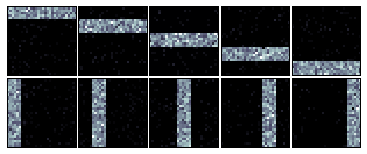

In [511]:
bnpy.viz.PlotComps.plotCompsFromHModel(finalModel)